<hr/>

# imports

In [ ]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn
import imblearn

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [3]:

def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [4]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [5]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse

    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    data['sender_labels_encoded'] = data['sender_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data['receiver_labels_encoded'] = data['receiver_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data["game_score_delta"] = data['game_score_delta'].astype(float)
    return data

In [6]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, skip_evaluation: bool = False) -> tuple[float, float]:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        skip_evaluation: bool
            skip the model.evaluate() function
    """
    def find_best_threshold(y_true, y_probs):
        best_threshold = 0.5
        best_f1 = 0.0

        # Iterate over a range of thresholds (e.g., 0.0 to 1.0)
        for threshold in np.arange(0.0, 1.0, 0.01):
            # Convert probabilities to binary predictions based on the current threshold
            y_pred = (y_probs > threshold).astype(int)

            # Calculate the F1 score
            f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')

            # If this F1 score is better than the best so far, update the best threshold and F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        return best_threshold, best_f1

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['sender_output_auc'], label='sender_output_auc', color="tan", linestyle="dashed")
    plt.plot(history.history['val_sender_output_auc'], label = 'val_sender_output_auc', color="darkorange")
    plt.plot(history.history['receiver_output_auc_1'], label='receiver_output_auc', color="cornflowerblue" , linestyle="dashed")
    plt.plot(history.history['val_receiver_output_auc_1'], label = 'val_receiver_output_auc', color="darkblue")
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.ylim([0.0, 1.03])
    plt.legend(loc='lower right')
    plt.show()

    if not skip_evaluation:
        print(f"{'='*10} Test Evaluation {'='*10}")
        model.evaluate(test_ds, test_target, verbose=2)
        # print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
        print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)

    # Find the best threshold for sender
    best_threshold_sender, best_f1_sender = find_best_threshold(test_target[0], y_pred[0])
    #print("Best Threshold for Sender:", best_threshold_sender, "with F1 Score:", best_f1_sender)

    # Find the best threshold for receiver
    best_threshold_receiver, best_f1_receiver = find_best_threshold(test_target[1], y_pred[1])
    #print("Best Threshold for Receiver:", best_threshold_receiver, "with F1 Score:", best_f1_receiver)

      # Convert probabilities to binary predictions
    y_pred_sender = (y_pred[0] > best_threshold_sender).astype(int).reshape(-1)
    y_pred_receiver = (y_pred[1] > best_threshold_receiver).astype(int).reshape(-1)

    print()
    print(f"{'-'*10} Sender Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[0], y_pred_sender, target_names=["True", "False"], zero_division=0, digits=3))
    print(f"{'-'*10} Receiver Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[1], y_pred_receiver, target_names=["True", "False"], zero_division=0, digits=3))

    return best_threshold_sender, best_threshold_receiver

In [7]:

def Tokenize(tokenizer, df: pd.DataFrame, sequence_len: int = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

In [8]:
def PredictionGridPeek(pred: list, df: pd.DataFrame, target_labels: list, who: str) -> pd.DataFrame:
    table = {
        "prediction": [],
        "target": [],
        "message": [],
        "context": []
    }
    for match in [True, False]:
        bool_stmt = pred == df[f'{who}_labels_encoded'] if match else pred != df[f'{who}_labels_encoded']
        visited = []
        for i in range(0, len(pred[bool_stmt])):
            row = df[bool_stmt].iloc[i,:]
            pred_label = target_labels[pred[bool_stmt][i]]
            if (pred_label, row[f'{who}_labels']) not in visited:
                table["prediction"].append(pred_label)
                table["target"].append(row[f'{who}_labels'])
                table['message'].append(row['messages'])
                table['context'].append(row['previous_message'])
                visited.append((pred_label, row[f'{who}_labels']))
                if len(visited) >= len(target_labels):
                    break
    return pd.DataFrame(table)

<hr/>

# data explortion

just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

## NOANNOTATION

In [9]:
# train_df = (parse_jsonl("./data/train.jsonl"))
# test_df = (parse_jsonl("./data/test.jsonl"))
# validation_df = (parse_jsonl("./data/validation.jsonl"))

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Colab Notebooks/w266 Final Project'

train_df = (parse_jsonl(f"{folder_path}/data/train.jsonl"))
test_df = (parse_jsonl(f"{folder_path}/data/test.jsonl"))
validation_df = (parse_jsonl(f"{folder_path}/data/validation.jsonl"))

Mounted at /content/drive


In [10]:

train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0.0,1,0,It seems like there are a lot of ways that cou...,straightforward,0,2


# NOANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value

In [11]:
print("NOANNOTATION percentage in:")
print(f'train = {(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index)) * 100:.2f}%')
print(f'test = {(len(test_df[test_df["receiver_labels"] == "NOANNOTATION"].index) /  len(test_df.index)) * 100:.2f}%')
print(f'validation = {(len(validation_df[validation_df["receiver_labels"] == "NOANNOTATION"].index) /  len(validation_df.index)) * 100:.2f}%')

NOANNOTATION percentage in:
train = 8.43%
test = 9.70%
validation = 9.39%


The percentages are low in each dataset and "NOANNOTATION" does not provide any meaningful value so we will remove it to keep the results a boolean value `True` or `False`.

In [12]:
train_df = train_df[train_df["receiver_labels"] != "NOANNOTATION"]
test_df = test_df[test_df['receiver_labels'] != "NOANNOTATION"]
validation_df = validation_df[validation_df['receiver_labels'] != "NOANNOTATION"]

# Unique Words

In [13]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 11
just: 1146
the: 6037
person: 28
i: 8250
want: 779
to: 10653
speak: 17
with.: 34
have: 1944
a: 4399
somewhat: 15
crazy: 15
idea: 89
that: 3414
i’ve: 139
always: 75
wanted: 136
try: 284
with: 2364
i/g,: 1
but: 2086
never: 96
actually: 195
convinced: 11
other: 271
guy: 29
it.: 244
and,: 34
what’s: 73
worse,: 3


In [14]:
len(unique_words)

14991

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

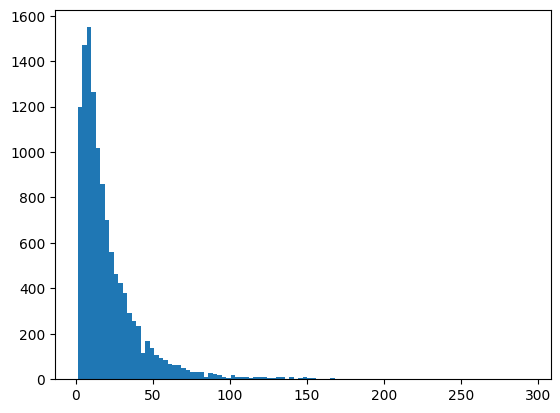

In [15]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [16]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,12025
1,Average words per message,20
2,Unique word count,14991
3,Actual Lie count,545
4,Actual Truth count,11480


# Label count

In [17]:
train_df['label'].value_counts()

straightforward    10979
cassandra            501
deceive              480
caught                65
Name: label, dtype: int64

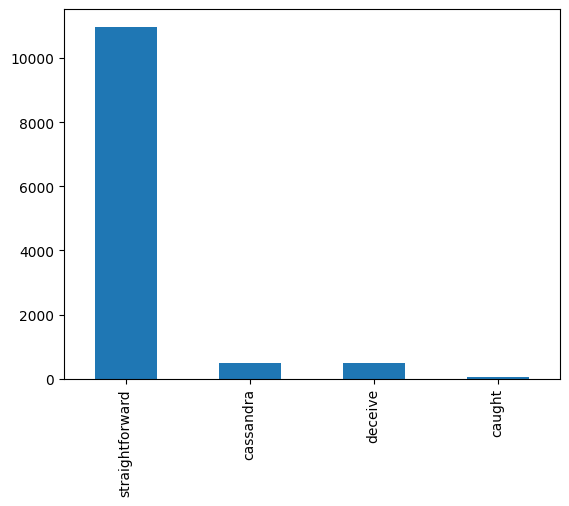

In [18]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [19]:
train_df['label'].value_counts(normalize=True)

straightforward    0.913015
cassandra          0.041663
deceive            0.039917
caught             0.005405
Name: label, dtype: float64

<hr/>

# Constants

In [20]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)
EMBEDDING_OUTPUT_SIZE = 124
LSTM_SIZE = 1024
DROPOUT_RATE = 0.15
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 2e-5

CLASS_LABELS = ["True", "False"]

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
# smote = imblearn.over_sampling.SMOTE()

# train_encoded_padded, y_train = smote.fit_resample(train_tokenized_padded, train_df['label_encoded'])
# train_prev_encoded_padded, y_train = smote.fit_resample(train_prev_tokenized_padded, train_df['label_encoded'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

In [21]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

In [22]:
from tokenizers import ByteLevelBPETokenizer

# Initialize a tokenizer
bpe_tokenizer = ByteLevelBPETokenizer()

# Get a list of all messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Train the tokenizer
bpe_tokenizer.train_from_iterator(all_messages, vocab_size=VOCAB_SIZE)

def bpe_tokenize_and_pad(tokenizer, col, max_length):
    input_ids = []

    for sent in col:
        encoded = tokenizer.encode(sent)
        # Padding and truncating
        padding_length = max_length - len(encoded.ids)
        ids = encoded.ids + [0] * padding_length if padding_length > 0 else encoded.ids[:max_length]
        input_ids.append(ids)

    return tf.convert_to_tensor(input_ids)

train_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, train_df['messages'], MAX_SEQUENCE_LEN)
test_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, test_df['messages'], MAX_SEQUENCE_LEN)
validation_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, validation_df['messages'], MAX_SEQUENCE_LEN)

train_prev_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, train_df['previous_message'], MAX_SEQUENCE_LEN)
test_prev_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, test_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_encoded_padded_bpe = bpe_tokenize_and_pad(bpe_tokenizer, validation_df['previous_message'], MAX_SEQUENCE_LEN)


In [23]:
# Load SpaCy model
import spacy
nlp = spacy.load('en_core_web_sm')

def extract_features(text):
    doc = nlp(text)
    features = {
        "pos_tags": [token.pos_ for token in doc],
        "ner_tags": [ent.label_ for ent in doc.ents],
        # Add more features as needed
    }
    return features


In [32]:
import spacy
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

# Load SpaCy model for English
nlp = spacy.load("en_core_web_sm")

def extract_pos_tags(texts, max_len):
    pos_tags = []
    for doc in nlp.pipe(texts):
        tags = [token.pos_ for token in doc]
        pos_tags.append(tags)
    pos_tag_index = {tag: i + 1 for i, tag in enumerate(set(tag for tags in pos_tags for tag in tags))}
    encoded_tags = [[pos_tag_index[tag] for tag in tags] for tags in pos_tags]
    padded_tags = pad_sequences(encoded_tags, maxlen=max_len, padding='post')
    return np.array(padded_tags)

# Extract POS tags from datasets
train_pos_tags = extract_pos_tags(train_df['messages'], MAX_SEQUENCE_LEN)
test_pos_tags = extract_pos_tags(test_df['messages'], MAX_SEQUENCE_LEN)
validation_pos_tags = extract_pos_tags(validation_df['messages'], MAX_SEQUENCE_LEN)

# Extract POS tags for previous messages
train_prev_pos_tags = extract_pos_tags(train_df['previous_message'], MAX_SEQUENCE_LEN)
test_prev_pos_tags = extract_pos_tags(test_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_pos_tags = extract_pos_tags(validation_df['previous_message'], MAX_SEQUENCE_LEN)

In [33]:
def extract_dependency_tags(texts, max_len):
    dep_tags = []
    for doc in nlp.pipe(texts):
        tags = [token.dep_ for token in doc]
        dep_tags.append(tags)

    # Create an index for dependency tags and encode them
    dep_tag_index = {tag: i + 1 for i, tag in enumerate(set(tag for tags in dep_tags for tag in tags))}
    encoded_tags = [[dep_tag_index[tag] for tag in tags] for tags in dep_tags]

    # Padding
    padded_tags = pad_sequences(encoded_tags, maxlen=max_len, padding='post')
    return np.array(padded_tags)

train_dep_tags = extract_dependency_tags(train_df['messages'], MAX_SEQUENCE_LEN)
test_dep_tags = extract_dependency_tags(test_df['messages'], MAX_SEQUENCE_LEN)
validation_dep_tags = extract_dependency_tags(validation_df['messages'], MAX_SEQUENCE_LEN)

train_prev_dep_tags = extract_dependency_tags(train_df['previous_message'], MAX_SEQUENCE_LEN)
test_prev_dep_tags = extract_dependency_tags(test_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_dep_tags = extract_dependency_tags(validation_df['previous_message'], MAX_SEQUENCE_LEN)


In [35]:
def extract_named_entities(texts, max_len):
    entity_labels = []
    for doc in nlp.pipe(texts):
        labels = [ent.label_ for ent in doc.ents]  # Get entity labels
        entity_labels.append(labels)

    # Create an index for entity labels and encode them
    entity_label_index = {label: i + 1 for i, label in enumerate(set(label for labels in entity_labels for label in labels))}
    encoded_labels = [[entity_label_index[label] for label in labels] for labels in entity_labels]

    # Padding
    padded_labels = pad_sequences(encoded_labels, maxlen=max_len, padding='post')
    return np.array(padded_labels)

train_entity_labels = extract_named_entities(train_df['messages'], MAX_SEQUENCE_LEN)
test_entity_labels = extract_named_entities(test_df['messages'], MAX_SEQUENCE_LEN)
validation_entity_labels = extract_named_entities(validation_df['messages'], MAX_SEQUENCE_LEN)

train_prev_entity_labels = extract_named_entities(train_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_entity_labels = extract_named_entities(validation_df['messages'], MAX_SEQUENCE_LEN)
test_prev_entity_labels = extract_named_entities(test_df['previous_message'], MAX_SEQUENCE_LEN)


In [25]:
# Reshape 'game_score_delta' to have an additional dimension
train_power_diff = train_df['game_score_delta']
test_power_diff = test_df['game_score_delta']
validation_power_diff = validation_df['game_score_delta']

# Unigram Tokenizer

In [26]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00


In [27]:
# Assuming all_messages is a list of text messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Write messages to a text file
with open('all_messages.txt', 'w', encoding='utf-8') as file:
    for message in all_messages:
        file.write(message + '\n')

In [28]:
train_df

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
7,"Sorry Italy I've been away doing, um, German t...",True,True,germany,italy,117,7,Spring,1901,3,0.0,1,0,Any thoughts?,straightforward,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,Is there any way of me actually ending this co...,True,True,france,england,380,11,Fall,1902,4,-1.0,10,187,I guess we will see what happens,straightforward,0,0
13128,Can we agree on peace? What are your demands?,True,True,france,england,433,12,Fall,1902,4,-1.0,10,187,Is there any way of me actually ending this co...,straightforward,0,0
13129,"Neutrality in exchange for current holdings, S...",True,False,england,france,434,13,Fall,1902,5,1.0,10,187,Can we agree on peace? What are your demands?,cassandra,0,1
13130,"Thats a bit too much, can I keep Spain and i h...",True,True,france,england,437,14,Fall,1902,4,-1.0,10,187,"Neutrality in exchange for current holdings, S...",straightforward,0,0


In [29]:
# Assuming all_messages is a list of text messages
all_messages = train_df['messages'].tolist() + test_df['messages'].tolist() + validation_df['messages'].tolist()

# Write messages to a text file
with open('all_messages.txt', 'w', encoding='utf-8') as file:
    for message in all_messages:
        file.write(message + '\n')

import sentencepiece as spm

# Train the unigram tokenizer
sp = spm.SentencePieceProcessor()
spm.SentencePieceTrainer.train(input='all_messages.txt', model_prefix='unigram', vocab_size=VOCAB_SIZE, model_type='unigram')

# Load the trained model
sp.load('unigram.model')

def unigram_tokenize_and_pad(sp, col, max_length):
    input_ids = []

    for sent in col:
        encoded = sp.encode_as_ids(sent)
        # Padding and truncating
        padding_length = max_length - len(encoded)
        ids = encoded + [0] * padding_length if padding_length > 0 else encoded[:max_length]
        input_ids.append(ids)

    return tf.convert_to_tensor(input_ids)

# Preprocess your data
train_encoded_padded_unigram = unigram_tokenize_and_pad(sp, train_df['messages'], MAX_SEQUENCE_LEN)
test_encoded_padded_unigram = unigram_tokenize_and_pad(sp, test_df['messages'], MAX_SEQUENCE_LEN)
validation_encoded_padded_unigram = unigram_tokenize_and_pad(sp, validation_df['messages'], MAX_SEQUENCE_LEN)

# Tokenize and pad previous messages using the Unigram tokenizer
train_prev_encoded_padded_unigram = unigram_tokenize_and_pad(sp, train_df['previous_message'], MAX_SEQUENCE_LEN)
test_prev_encoded_padded_unigram = unigram_tokenize_and_pad(sp, test_df['previous_message'], MAX_SEQUENCE_LEN)
validation_prev_encoded_padded_unigram = unigram_tokenize_and_pad(sp, validation_df['previous_message'], MAX_SEQUENCE_LEN)



In [37]:
from tensorflow import keras
import tensorflow as tf

def create_context_bilstm_model_unigram_with_power(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = 1024,
        dropout: float = 0.15,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = 2e-5,
    ):

    # Inputs
    current_message_input_unigram = keras.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input_unigram = keras.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.Input(shape=(1,), name='power_differential')

    # Embedding layer
    embedding_layer = keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Bi-LSTM layers applied to the current and previous messages
    current_message_embedded = embedding_layer(current_message_input_unigram)
    current_message_bilstm_unigram = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(current_message_embedded)
    current_message_bilstm_unigram = keras.layers.Dropout(dropout)(current_message_bilstm_unigram)

    previous_message_embedded = embedding_layer(previous_message_input_unigram)
    previous_message_bilstm_unigram = keras.layers.Bidirectional(keras.layers.LSTM(lstm_size))(previous_message_embedded)
    previous_message_bilstm_unigram = keras.layers.Dropout(dropout)(previous_message_bilstm_unigram)

    # Concatenate Bi-LSTM outputs with power differential input
    context_bilstm_power_output = keras.layers.Concatenate()([
        current_message_bilstm_unigram,
        previous_message_bilstm_unigram,
        power_diff_input
    ])
    context_bilstm_power_output = keras.layers.Dense(hidden_size, activation='relu')(context_bilstm_power_output)

    # Outputs
    sender_output = keras.layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_power_output)
    receiver_output = keras.layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_power_output)

    # Model
    context_bilstm_model_unigram_with_power = keras.Model(
        inputs=[current_message_input_unigram, previous_message_input_unigram, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_model_unigram_with_power.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_model_unigram_with_power


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_6 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inpu

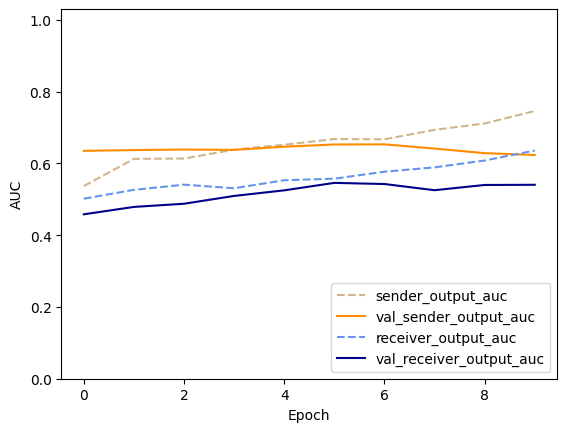

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5210 - sender_output_loss: 0.2798 - receiver_output_loss: 0.2412 - sender_output_auc: 0.6671 - receiver_output_auc_1: 0.6209 - 5s/epoch - 69ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 66ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.929     0.953     0.941      2268
       False      0.279     0.198     0.232       207

    accuracy                          0.890      2475
   macro avg      0.604     0.576     0.586      2475
weighted avg      0.874     0.890     0.882      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.942     0.885     0.913      2310
       False      0.128     0.236     0.166       165

    accuracy                          0.842      2475
   macro avg      0.535     0.561     0.539      2475
weighted avg      0.888     0

In [42]:
# Create the model
context_bilstm_power_unigram_model = create_context_bilstm_model_unigram_with_power(
    sequence_length=MAX_SEQUENCE_LEN,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.15,
    hidden_size=HIDDEN_LAYER_SIZE,
    learning_rate = 2e-5
)
context_bilstm_power_unigram_model.summary()

# Tokenize and pad data
# Assuming you have tokenized and padded your training, validation, and test data
# with the unigram tokenizer and prepared your power differential inputs as `train_power_diff`, `validation_power_diff`, `test_power_diff`

# Training the model
context_bilstm_power_unigram_history = context_bilstm_power_unigram_model.fit(
    [train_encoded_padded_unigram, train_prev_encoded_padded_unigram, train_power_diff],  # Including reshaped power differential input
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded_unigram, validation_prev_encoded_padded_unigram, validation_power_diff],  # Including reshaped power differential input
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=10
)

# EvaluateModel function should be defined to evaluate your model
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_power_unigram_model,
    [test_encoded_padded_unigram, test_prev_encoded_padded_unigram, test_power_diff],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_power_unigram_history
)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_4 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inpu

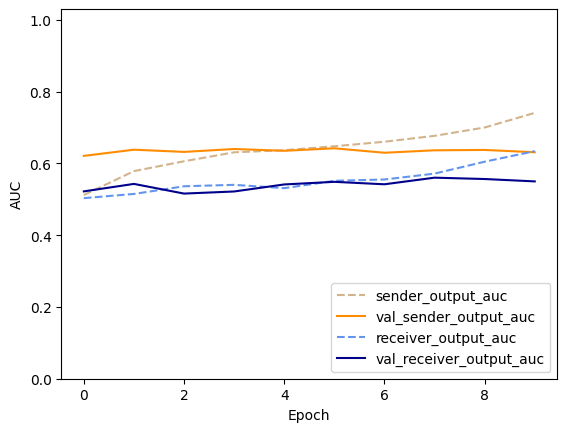

========== Test Evaluation ==========
78/78 - 5s - loss: 0.5713 - sender_output_loss: 0.3161 - receiver_output_loss: 0.2552 - sender_output_auc: 0.6727 - receiver_output_auc_1: 0.6250 - 5s/epoch - 67ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 65ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.937     0.899     0.917      2268
       False      0.231     0.333     0.273       207

    accuracy                          0.851      2475
   macro avg      0.584     0.616     0.595      2475
weighted avg      0.878     0.851     0.863      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.938     0.953     0.946      2310
       False      0.156     0.121     0.137       165

    accuracy                          0.898      2475
   macro avg      0.547     0.537     0.541      2475
weighted avg      0.886     0

In [40]:
from tensorflow.keras import layers, models

def create_context_bilstm_cnn_model_unigram_with_power(
        sequence_length,
        embedding_output,
        vocab_size,
        lstm_size,
        dropout,
        hidden_size,
        learning_rate,
        num_filters,  # Number of filters for the Conv1D layers
        kernel_size   # Size of the kernel for the Conv1D layers
    ):
    # Inputs
    current_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = layers.Input(shape=(1,), name='power_differential')

    # Embedding layer
    embedding = layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Embed current and previous messages
    current_embed = embedding(current_message_input)
    previous_embed = embedding(previous_message_input)

    # CNN layers for current and previous messages
    current_cnn = layers.Conv1D(num_filters, kernel_size, activation='relu')(current_embed)
    previous_cnn = layers.Conv1D(num_filters, kernel_size, activation='relu')(previous_embed)

    # Bi-LSTM layers
    current_bilstm = layers.Bidirectional(layers.LSTM(lstm_size))(current_cnn)
    previous_bilstm = layers.Bidirectional(layers.LSTM(lstm_size))(previous_cnn)

    # Concatenate Bi-LSTM outputs with power differential input
    context_bilstm_cnn_output = layers.Concatenate()([
        current_bilstm,
        previous_bilstm,
        power_diff_input
    ])
    context_bilstm_cnn_output = layers.Dense(hidden_size, activation='relu')(context_bilstm_cnn_output)

    # Outputs
    sender_output = layers.Dense(1, activation='sigmoid', name="sender_output")(context_bilstm_cnn_output)
    receiver_output = layers.Dense(1, activation='sigmoid', name="receiver_output")(context_bilstm_cnn_output)

    # Model
    context_bilstm_cnn_model = models.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    # Compile
    context_bilstm_cnn_model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return context_bilstm_cnn_model

    # Define additional parameters for CNN layers
num_filters = 64
kernel_size = 3

# Create the model with CNN component
context_bilstm_cnn_model = create_context_bilstm_cnn_model_unigram_with_power(
    sequence_length=MAX_SEQUENCE_LEN,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.1,
    hidden_size=HIDDEN_LAYER_SIZE,
    learning_rate=2e-5,
    num_filters=num_filters,
    kernel_size=kernel_size
)

# Model summary
context_bilstm_cnn_model.summary()

# Training the model
context_bilstm_cnn_history = context_bilstm_cnn_model.fit(
    [train_encoded_padded_unigram, train_prev_encoded_padded_unigram, train_power_diff],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded_unigram, validation_prev_encoded_padded_unigram, validation_power_diff],
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=10
)

# Evaluate the model
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_cnn_model,
    [test_encoded_padded_unigram, test_prev_encoded_padded_unigram, test_power_diff],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_cnn_history
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_1 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    , 'previous_message_inpu

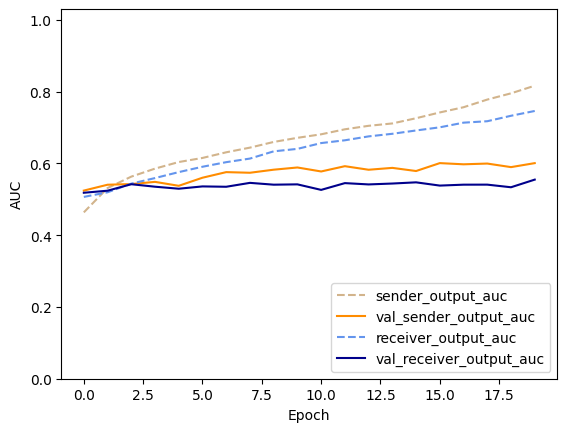

========== Test Evaluation ==========
78/78 - 5s - loss: 0.6178 - sender_output_loss: 0.3391 - receiver_output_loss: 0.2786 - sender_output_auc: 0.5369 - receiver_output_auc_1: 0.4803 - 5s/epoch - 69ms/step

========== Test Metrics ==========
78/78 [==============================] - 6s 67ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.925     0.892     0.908      2268
       False      0.146     0.203     0.170       207

    accuracy                          0.834      2475
   macro avg      0.535     0.547     0.539      2475
weighted avg      0.859     0.834     0.846      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.934     0.924     0.929      2310
       False      0.074     0.085     0.079       165

    accuracy                          0.868      2475
   macro avg      0.504     0.505     0.504      2475
weighted avg      0.877     0

In [36]:
def create_context_bilstm_cnn_spacy_model_with_extra_features(
        sequence_length, embedding_output, vocab_size, lstm_size, dropout, hidden_size,
        learning_rate, num_filters, kernel_size, pos_tags_dim, dep_tags_dim, ner_dim):
    # Inputs for message, power differential, POS tags, dependency tags, and NER features
    current_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = layers.Input(shape=(1,), name='power_differential')
    current_pos_input = layers.Input(shape=(pos_tags_dim,), name='current_pos_input')
    previous_pos_input = layers.Input(shape=(pos_tags_dim,), name='previous_pos_input')
    current_dep_input = layers.Input(shape=(dep_tags_dim,), name='current_dep_input')
    previous_dep_input = layers.Input(shape=(dep_tags_dim,), name='previous_dep_input')
    current_ner_input = layers.Input(shape=(ner_dim,), name='current_ner_input')
    previous_ner_input = layers.Input(shape=(ner_dim,), name='previous_ner_input')

    # Embedding layer
    embedding = layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Embed current and previous messages
    current_embed = embedding(current_message_input)
    previous_embed = embedding(previous_message_input)

    # CNN layers for current and previous messages
    current_cnn = layers.Conv1D(num_filters, kernel_size, activation='relu')(current_embed)
    previous_cnn = layers.Conv1D(num_filters, kernel_size, activation='relu')(previous_embed)

    # Bi-LSTM layers
    current_bilstm = layers.Bidirectional(layers.LSTM(lstm_size))(current_cnn)
    previous_bilstm = layers.Bidirectional(layers.LSTM(lstm_size))(previous_cnn)

    # Concatenate all inputs
    combined_features = layers.Concatenate()([
        current_bilstm, previous_bilstm, current_pos_input, previous_pos_input,
        current_dep_input, previous_dep_input, current_ner_input, previous_ner_input, power_diff_input
    ])

    # Dense layers
    dense_output = layers.Dense(hidden_size, activation='relu')(combined_features)

    # Output layers
    sender_output = layers.Dense(1, activation='sigmoid', name="sender_output")(dense_output)
    receiver_output = layers.Dense(1, activation='sigmoid', name="receiver_output")(dense_output)

    # Build the Model
    model = models.Model(
        inputs=[
            current_message_input, previous_message_input, current_pos_input, previous_pos_input,
            current_dep_input, previous_dep_input, current_ner_input, previous_ner_input, power_diff_input
        ],
        outputs=[sender_output, receiver_output]
    )

    # Compile the Model
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model


# Create the model with additional features
context_bilstm_cnn_spacy_extra_features_model = create_context_bilstm_cnn_spacy_model_with_extra_features(
    sequence_length=MAX_SEQUENCE_LEN,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=1024,
    dropout=0.15,
    hidden_size=HIDDEN_LAYER_SIZE,
    learning_rate=1e-5,
    num_filters=num_filters,
    kernel_size=kernel_size,
    pos_tags_dim=train_pos_tags.shape[1],
    dep_tags_dim=train_dep_tags.shape[1],
    ner_dim=train_entity_labels.shape[1]
)

# Model summary
context_bilstm_cnn_spacy_extra_features_model.summary()

# Training the model
context_bilstm_cnn_spacy_extra_features_history = context_bilstm_cnn_spacy_extra_features_model.fit(
    [train_encoded_padded_unigram, train_prev_encoded_padded_unigram, train_pos_tags, train_prev_pos_tags,
     train_dep_tags, train_prev_dep_tags, train_entity_labels, train_prev_entity_labels, train_power_diff],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded_unigram, validation_prev_encoded_padded_unigram, validation_pos_tags, validation_prev_pos_tags,
         validation_dep_tags, validation_prev_dep_tags, validation_entity_labels, validation_prev_entity_labels, validation_power_diff],
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=20
)

# Evaluate the model
sender_threshold, receiver_threshold = EvaluateModel(
    context_bilstm_cnn_spacy_extra_features_model,
    [test_encoded_padded_unigram, test_prev_encoded_padded_unigram, test_pos_tags, test_prev_pos_tags,
     test_dep_tags, test_prev_dep_tags, test_entity_labels, test_prev_entity_labels, test_power_diff],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    context_bilstm_cnn_spacy_extra_features_history
)


Epoch 1/20
94/94 [==============================] - 96s 771ms/step - loss: 0.5158 - sender_output_loss: 0.2594 - receiver_output_loss: 0.2564 - sender_output_auc: 0.4712 - receiver_output_auc_1: 0.5004 - val_loss: 0.3224 - val_sender_output_loss: 0.1635 - val_receiver_output_loss: 0.1589 - val_sender_output_auc: 0.5893 - val_receiver_output_auc_1: 0.4884
Epoch 2/20
94/94 [==============================] - 67s 716ms/step - loss: 0.3803 - sender_output_loss: 0.1859 - receiver_output_loss: 0.1945 - sender_output_auc: 0.5710 - receiver_output_auc_1: 0.5094 - val_loss: 0.3271 - val_sender_output_loss: 0.1657 - val_receiver_output_loss: 0.1614 - val_sender_output_auc: 0.6067 - val_receiver_output_auc_1: 0.5111
Epoch 3/20
94/94 [==============================] - 66s 698ms/step - loss: 0.3753 - sender_output_loss: 0.1827 - receiver_output_loss: 0.1926 - sender_output_auc: 0.5994 - receiver_output_auc_1: 0.5323 - val_loss: 0.3191 - val_sender_output_loss: 0.1611 - val_receiver_output_loss: 0.15

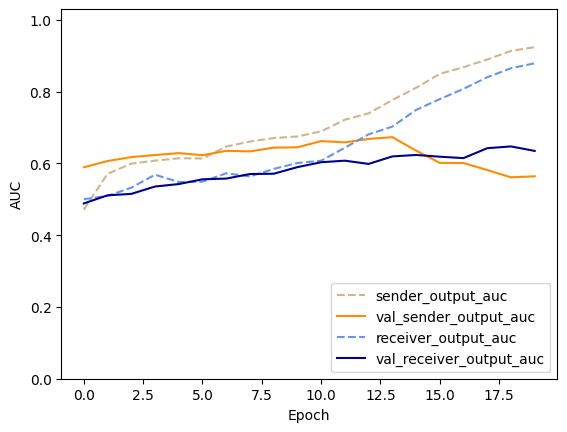

========== Test Evaluation ==========
78/78 - 11s - loss: 0.6133 - sender_output_loss: 0.3329 - receiver_output_loss: 0.2804 - sender_output_auc: 0.6234 - receiver_output_auc_1: 0.5435 - 11s/epoch - 139ms/step

========== Test Metrics ==========
78/78 [==============================] - 14s 137ms/step

---------- Sender Labels ----------
              precision    recall  f1-score   support

        True      0.925     0.931     0.928      2268
       False      0.188     0.174     0.180       207

    accuracy                          0.868      2475
   macro avg      0.556     0.553     0.554      2475
weighted avg      0.863     0.868     0.866      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True      0.938     0.957     0.947      2310
       False      0.153     0.109     0.127       165

    accuracy                          0.900      2475
   macro avg      0.545     0.533     0.537      2475
weighted avg      0.885 

In [30]:
def create_combined_model(sequence_length, embedding_output, vocab_size, lstm_size, dropout, hidden_size, learning_rate, pos_tags_dim):
    # Keras Message Inputs
    current_message_input_keras = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input_keras')
    previous_message_input_keras = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input_keras')

    # Unigram and BPE Message Inputs
    current_message_input_unigram = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input_unigram')
    previous_message_input_unigram = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input_unigram')
    current_message_input_bpe = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input_bpe')
    previous_message_input_bpe = layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input_bpe')

    # POS tags input
    current_pos_input = layers.Input(shape=(pos_tags_dim,), name='current_pos_input')
    previous_pos_input = layers.Input(shape=(pos_tags_dim,), name='previous_pos_input')

    # Power differential input
    power_diff_input = layers.Input(shape=(1,), name='power_differential')

    # Embedding layer
    embedding = layers.Embedding(vocab_size, embedding_output, input_length=sequence_length)

    # Bi-LSTM layers for each text input type
    def process_text_input(input_layer):
        embedded = embedding(input_layer)
        return layers.Bidirectional(layers.LSTM(lstm_size))(embedded)

    current_keras_bilstm = process_text_input(current_message_input_keras)
    previous_keras_bilstm = process_text_input(previous_message_input_keras)
    current_unigram_bilstm = process_text_input(current_message_input_unigram)
    previous_unigram_bilstm = process_text_input(previous_message_input_unigram)
    current_bpe_bilstm = process_text_input(current_message_input_bpe)

    previous_bpe_bilstm = process_text_input(previous_message_input_bpe)

    # Dense layer for SpaCy features
    spacy_dense = layers.Dense(hidden_size, activation='relu')(current_pos_input)  # Assuming similar processing for current and previous

    # Concatenate all inputs
    concatenated = layers.Concatenate()([
        current_keras_bilstm, previous_keras_bilstm, current_unigram_bilstm, previous_unigram_bilstm,
        current_bpe_bilstm, previous_bpe_bilstm, spacy_dense, power_diff_input
    ])

    # Dense layers
    dense_output = layers.Dense(hidden_size, activation='relu')(concatenated)
    dense_output = layers.Dropout(dropout)(dense_output)

    # Output layers
    sender_output = layers.Dense(1, activation='sigmoid', name='sender_output')(dense_output)
    receiver_output = layers.Dense(1, activation='sigmoid', name='receiver_output')(dense_output)

    # Build the model
    model = models.Model(
        inputs=[
            current_message_input_keras, previous_message_input_keras, current_message_input_unigram, previous_message_input_unigram,
            current_message_input_bpe, previous_message_input_bpe, current_pos_input, previous_pos_input, power_diff_input
        ],
        outputs=[sender_output, receiver_output]
    )

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )

    return model

# Create and compile the model
combined_model = create_combined_model(
    sequence_length=MAX_SEQUENCE_LEN,
    embedding_output=EMBEDDING_OUTPUT_SIZE,
    vocab_size=VOCAB_SIZE,
    lstm_size=600,
    dropout=0.2,
    hidden_size=HIDDEN_LAYER_SIZE,
    learning_rate=3e-5,
    pos_tags_dim=train_pos_tags.shape[1]
)

# Train the model
combined_model_history = combined_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_encoded_padded_unigram, train_prev_encoded_padded_unigram,
     train_encoded_padded_bpe, train_prev_encoded_padded_bpe, train_pos_tags, train_pos_tags, train_power_diff],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(
        [validation_encoded_padded, validation_prev_encoded_padded, validation_encoded_padded_unigram, validation_prev_encoded_padded_unigram,
         validation_encoded_padded_bpe, validation_prev_encoded_padded_bpe, validation_pos_tags, validation_pos_tags, validation_power_diff],
        [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]
    ),
    epochs=20,
    batch_size=128
)

# Evaluate the model
sender_threshold, receiver_threshold = EvaluateModel(
    combined_model,
    [test_encoded_padded, test_prev_encoded_padded, test_encoded_padded_unigram, test_prev_encoded_padded_unigram,
     test_encoded_padded_bpe, test_prev_encoded_padded_bpe, test_pos_tags, test_pos_tags, test_power_diff],
    [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']],
    combined_model_history
)
